In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import pandas as pd

# Define file names for stock prices
stock_files = ['A.csv', 'AA.csv', 'AACG.csv', 'AAL.csv', 'AAMC.csv',
               'AAN.csv', 'AAOI.csv', 'AAON.csv', 'AAP.csv', 'AAPL.csv']

# Load stock data into a list of DataFrames
stock_dfs = [pd.read_csv(file) for file in stock_files]

# Load sentiment analysis data with encoding handling
try:
    sentiment_df = pd.read_csv('all-data.csv', encoding='ISO-8859-1')  # You can try 'latin1' or 'cp1252' if needed
except UnicodeDecodeError:
    sentiment_df = pd.read_csv('all-data.csv', encoding='cp1252')

# Print the first few rows of one of the stock DataFrames to verify
print("Stock Data Example:")
print(stock_dfs[0].head())

# Print the first few rows of the sentiment analysis DataFrame to verify
print("\nSentiment Analysis Data:")
print(sentiment_df.head())


Stock Data Example:
         Date       Open       High        Low      Close  Adj Close    Volume
0  1999-11-18  32.546494  35.765381  28.612303  31.473534  27.068665  62546300
1  1999-11-19  30.713520  30.758226  28.478184  28.880543  24.838577  15234100
2  1999-11-22  29.551144  31.473534  28.657009  31.473534  27.068665   6577800
3  1999-11-23  30.400572  31.205294  28.612303  28.612303  24.607880   5975600
4  1999-11-24  28.701717  29.998211  28.612303  29.372318  25.261524   4843200

Sentiment Analysis Data:
    neutral  \
0   neutral   
1  negative   
2  positive   
3  positive   
4  positive   

  According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .  
0  Technopolis plans to develop in stages an area...                                                                               
1  The international electronic industry company ...                                                                         

In [4]:
# Preprocessing Sentiment Data

# Rename columns of sentiment DataFrame for clarity (assuming first column is sentiment and second is text)
sentiment_df.columns = ['Sentiment', 'Text']

# Convert sentiment labels to numerical scores
sentiment_df['Sentiment_Score'] = sentiment_df['Sentiment'].map({'positive': 1, 'neutral': 0, 'negative': -1})

# Check the first few rows to confirm changes
print("Preprocessed Sentiment Data:")
print(sentiment_df.head())

# Prepare stock price data
for df in stock_dfs:
    df['Date'] = pd.to_datetime(df['Date'])  # Convert Date column to datetime format

# Check the first few rows of one stock DataFrame to confirm changes
print("\nStock Data with Date as Datetime:")
print(stock_dfs[0].head())


Preprocessed Sentiment Data:
  Sentiment                                               Text  \
0   neutral  Technopolis plans to develop in stages an area...   
1  negative  The international electronic industry company ...   
2  positive  With the new production plant the company woul...   
3  positive  According to the company 's updated strategy f...   
4  positive  FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...   

   Sentiment_Score  
0                0  
1               -1  
2                1  
3                1  
4                1  

Stock Data with Date as Datetime:
        Date       Open       High        Low      Close  Adj Close    Volume
0 1999-11-18  32.546494  35.765381  28.612303  31.473534  27.068665  62546300
1 1999-11-19  30.713520  30.758226  28.478184  28.880543  24.838577  15234100
2 1999-11-22  29.551144  31.473534  28.657009  31.473534  27.068665   6577800
3 1999-11-23  30.400572  31.205294  28.612303  28.612303  24.607880   5975600
4 1999-11-24  28.701717

In [5]:
# Step 4: Merging Sentiment Data with Stock Price Data

# Create a 'Date' column in sentiment_df by assuming it represents a daily summary (if not present, add appropriately)
# This step assumes we need a date column and aligns sentiment with stock data; replace this logic as per actual data
sentiment_df['Date'] = pd.date_range(start='1999-11-18', periods=len(sentiment_df), freq='D')

# Aggregate sentiment scores by date
sentiment_daily = sentiment_df.groupby('Date')['Sentiment_Score'].mean().reset_index()

# Merge each stock DataFrame with the aggregated daily sentiment scores
merged_dfs = []
for stock_df in stock_dfs:
    merged_df = pd.merge(stock_df, sentiment_daily, on='Date', how='left')
    merged_dfs.append(merged_df)

# Print the first few rows of the merged DataFrame to verify
print("Merged DataFrame Example:")
print(merged_dfs[0].head())


Merged DataFrame Example:
        Date       Open       High        Low      Close  Adj Close    Volume  \
0 1999-11-18  32.546494  35.765381  28.612303  31.473534  27.068665  62546300   
1 1999-11-19  30.713520  30.758226  28.478184  28.880543  24.838577  15234100   
2 1999-11-22  29.551144  31.473534  28.657009  31.473534  27.068665   6577800   
3 1999-11-23  30.400572  31.205294  28.612303  28.612303  24.607880   5975600   
4 1999-11-24  28.701717  29.998211  28.612303  29.372318  25.261524   4843200   

   Sentiment_Score  
0              0.0  
1             -1.0  
2              1.0  
3              1.0  
4              1.0  


In [6]:
# Step 5: Feature Engineering

# Define the lag days
lag_days = 1

# Add lagged features and moving average
for merged_df in merged_dfs:
    # Lagged Closing Price
    merged_df[f'Close_Lag_{lag_days}'] = merged_df['Close'].shift(lag_days)

    # Lagged Sentiment Score
    merged_df[f'Sentiment_Score_Lag_{lag_days}'] = merged_df['Sentiment_Score'].shift(lag_days)

    # 3-day Moving Average of Closing Price
    merged_df['Close_MA_3'] = merged_df['Close'].rolling(window=3).mean()

# Print the first few rows of the modified DataFrame to verify
print("Feature Engineered DataFrame Example:")
print(merged_dfs[0].head())


Feature Engineered DataFrame Example:
        Date       Open       High        Low      Close  Adj Close    Volume  \
0 1999-11-18  32.546494  35.765381  28.612303  31.473534  27.068665  62546300   
1 1999-11-19  30.713520  30.758226  28.478184  28.880543  24.838577  15234100   
2 1999-11-22  29.551144  31.473534  28.657009  31.473534  27.068665   6577800   
3 1999-11-23  30.400572  31.205294  28.612303  28.612303  24.607880   5975600   
4 1999-11-24  28.701717  29.998211  28.612303  29.372318  25.261524   4843200   

   Sentiment_Score  Close_Lag_1  Sentiment_Score_Lag_1  Close_MA_3  
0              0.0          NaN                    NaN         NaN  
1             -1.0    31.473534                    0.0         NaN  
2              1.0    28.880543                   -1.0   30.609203  
3              1.0    31.473534                    1.0   29.655460  
4              1.0    28.612303                    1.0   29.819385  


In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Example: Using the first merged DataFrame for training
# Adjust the following lines if you want to use a different DataFrame or loop through all

# Define feature columns and target column
feature_cols = ['Close_Lag_1', 'Sentiment_Score_Lag_1', 'Close_MA_3']
target_col = 'Close'

# Drop rows with NaN values created by shifting and moving average
train_df = merged_dfs[0].dropna(subset=feature_cols + [target_col])

# Split data into features and target
X = train_df[feature_cols]
y = train_df[target_col]

# Split the data into training and testing sets (80-20 split)
split_index = int(0.8 * len(train_df))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 0.48075280875864174
Root Mean Squared Error (RMSE): 0.6361876265328601


In [8]:
# Step 6: Advanced Feature Engineering

# Function to add technical indicators
def add_technical_indicators(df):
    # Add Moving Averages
    df['Close_MA_5'] = df['Close'].rolling(window=5).mean()
    df['Close_MA_10'] = df['Close'].rolling(window=10).mean()

    # Add Bollinger Bands
    df['Close_STD_10'] = df['Close'].rolling(window=10).std()
    df['Bollinger_Upper'] = df['Close_MA_10'] + (df['Close_STD_10'] * 2)
    df['Bollinger_Lower'] = df['Close_MA_10'] - (df['Close_STD_10'] * 2)

    # Add Relative Strength Index (RSI)
    delta = df['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    return df

# Apply feature engineering to each DataFrame
for merged_df in merged_dfs:
    merged_df = add_technical_indicators(merged_df)
    merged_df['Close_Lag_1'] = merged_df['Close'].shift(1)
    merged_df['Sentiment_Score_Lag_1'] = merged_df['Sentiment_Score'].shift(1)
    merged_df['Close_MA_3'] = merged_df['Close'].rolling(window=3).mean()

# Print the first few rows of the modified DataFrame to verify
print("Advanced Feature Engineered DataFrame Example:")
print(merged_dfs[0].head())


Advanced Feature Engineered DataFrame Example:
        Date       Open       High        Low      Close  Adj Close    Volume  \
0 1999-11-18  32.546494  35.765381  28.612303  31.473534  27.068665  62546300   
1 1999-11-19  30.713520  30.758226  28.478184  28.880543  24.838577  15234100   
2 1999-11-22  29.551144  31.473534  28.657009  31.473534  27.068665   6577800   
3 1999-11-23  30.400572  31.205294  28.612303  28.612303  24.607880   5975600   
4 1999-11-24  28.701717  29.998211  28.612303  29.372318  25.261524   4843200   

   Sentiment_Score  Close_Lag_1  Sentiment_Score_Lag_1  Close_MA_3  \
0              0.0          NaN                    NaN         NaN   
1             -1.0    31.473534                    0.0         NaN   
2              1.0    28.880543                   -1.0   30.609203   
3              1.0    31.473534                    1.0   29.655460   
4              1.0    28.612303                    1.0   29.819385   

   Close_MA_5  Close_MA_10  Close_STD_10  Bol

In [9]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Example: Using the first merged DataFrame for training
train_df = merged_dfs[0].dropna()  # Drop rows with NaN values

# Define feature columns (include all new features)
feature_cols = ['Close_Lag_1', 'Sentiment_Score_Lag_1', 'Close_MA_3', 'Close_MA_5',
                'Close_MA_10', 'Bollinger_Upper', 'Bollinger_Lower', 'RSI']
target_col = 'Close'

# Split data into features and target
X = train_df[feature_cols]
y = train_df[target_col]

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(xgb_model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
mean_cv_mae = -cv_scores.mean()

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Cross-Validated Mean Absolute Error (MAE): {mean_cv_mae}")
print(f"Test Set Mean Absolute Error (MAE): {mae}")
print(f"Test Set Root Mean Squared Error (RMSE): {rmse}")


Cross-Validated Mean Absolute Error (MAE): 0.4394126219725347
Test Set Mean Absolute Error (MAE): 0.45764003983117585
Test Set Root Mean Squared Error (RMSE): 0.8605847181536732


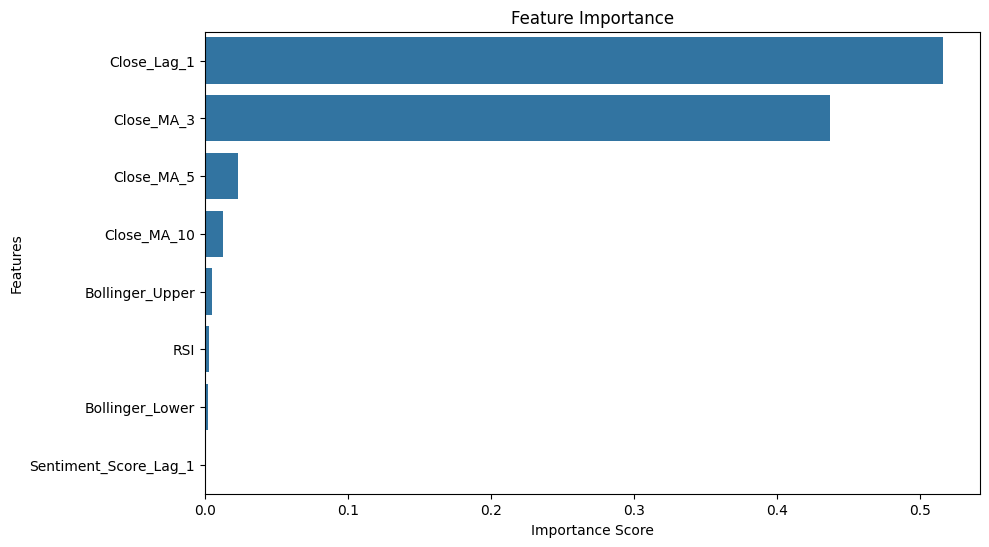

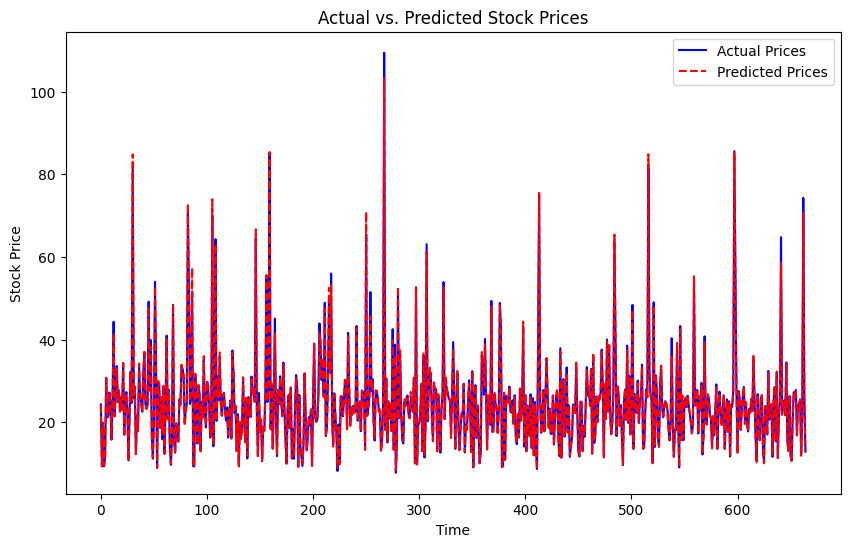

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Importance from XGBoost
feature_importance = xgb_model.feature_importances_
feature_names = feature_cols

# Create a DataFrame for plotting
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

# Plot actual vs. predicted prices
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Prices', color='blue', linestyle='-')
plt.plot(y_pred, label='Predicted Prices', color='red', linestyle='--')
plt.title('Actual vs. Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()



In [11]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize the XGBoost Regressor
xgb = XGBRegressor(random_state=42)

# Initialize Grid Search
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=1)

# Fit Grid Search
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validated Mean Absolute Error (MAE): {best_score}")

# Re-train the model with the best parameters on the entire training set
best_xgb_model = XGBRegressor(**best_params, random_state=42)
best_xgb_model.fit(X_train, y_train)

# Predict and evaluate on the test set
y_pred_best = best_xgb_model.predict(X_test)
mae_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))

print(f"Test Set Mean Absolute Error (MAE) after Tuning: {mae_best}")
print(f"Test Set Root Mean Squared Error (RMSE) after Tuning: {rmse_best}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}
Best Cross-Validated Mean Absolute Error (MAE): 0.4379994449846662
Test Set Mean Absolute Error (MAE) after Tuning: 0.4359802575935995
Test Set Root Mean Squared Error (RMSE) after Tuning: 0.8313961853449263


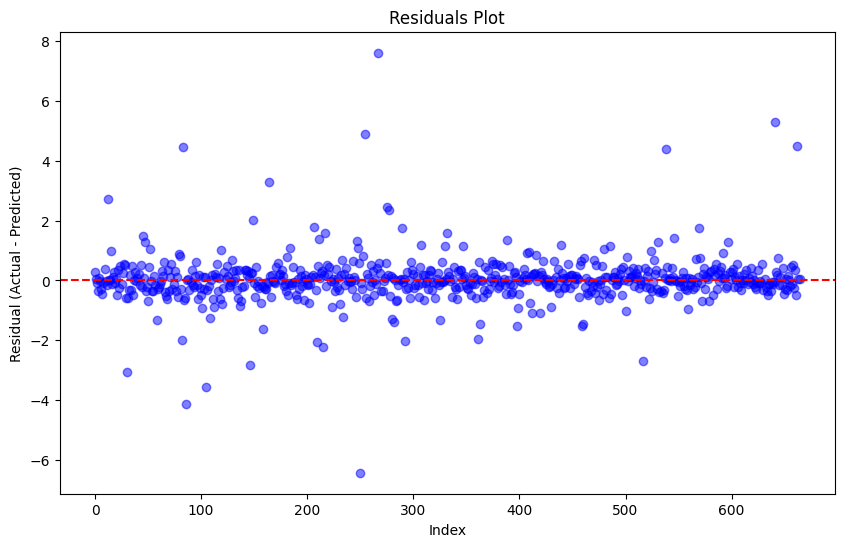

In [12]:
# Step 9: Residual Analysis

# Calculate residuals
residuals = y_test - y_pred_best

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals)), residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals Plot')
plt.xlabel('Index')
plt.ylabel('Residual (Actual - Predicted)')
plt.show()


In [14]:
!pip install shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 16.3 MB/s eta 0:00:00


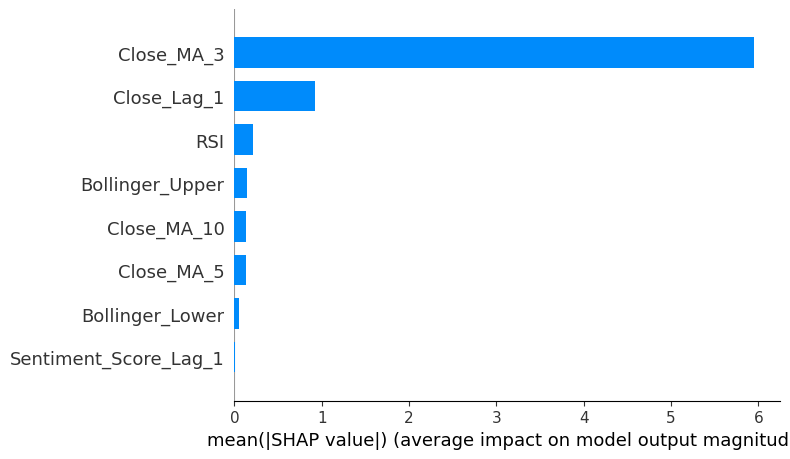

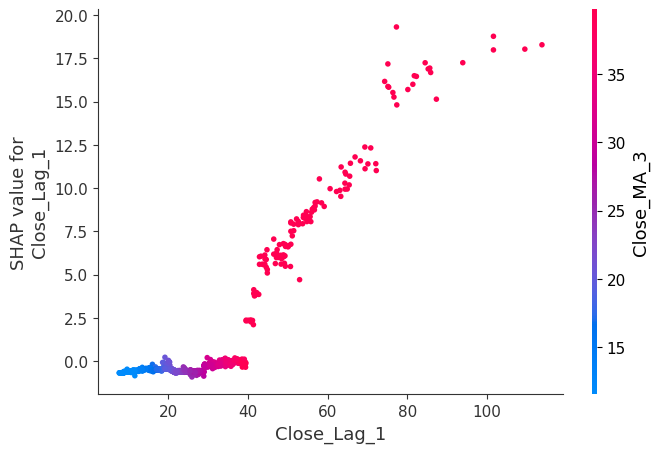

In [16]:
import shap

# Use TreeExplainer for XGBoost
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X_train)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_train, plot_type="bar")

# Plot SHAP dependence plot for an important feature
shap.dependence_plot(0, shap_values, X_train)  # Index '0' typically corresponds to the first feature (Close_Lag_1)


In [17]:
# Installing VADER sentiment analyzer if not already installed
!pip install vaderSentiment

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
vader_analyzer = SentimentIntensityAnalyzer()

# Example function to get VADER sentiment score for a given text
def get_vader_sentiment(text):
    sentiment = vader_analyzer.polarity_scores(text)
    return sentiment['compound']  # Return the compound score

# Apply VADER sentiment analysis on the text data
sentiment_df['VADER_Sentiment_Score'] = sentiment_df['Text'].apply(get_vader_sentiment)

# Display first few rows to check the sentiment score
print(sentiment_df[['Text', 'VADER_Sentiment_Score']].head())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.6 MB/s eta 0:00:00
                                                Text  VADER_Sentiment_Score
0  Technopolis plans to develop in stages an area...                -0.2960
1  The international electronic industry company ...                 0.0000
2  With the new production plant the company woul...                 0.8555
3  According to the company 's updated strategy f...                 0.6705
4  FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...                 0.3485


In [19]:
from transformers import pipeline

# Initialize the sentiment-analysis pipeline using a BERT-based model, specifying the device to use GPU
sentiment_pipeline = pipeline("sentiment-analysis", device=0)  # Use device=0 for GPU

# Example function to get BERT sentiment score for a given text
def get_bert_sentiment(text):
    sentiment = sentiment_pipeline(text)
    # Convert 'NEGATIVE'/'POSITIVE' to numerical score
    return 1 if sentiment[0]['label'] == 'POSITIVE' else -1

# Apply BERT sentiment analysis on the text data using GPU
sentiment_df['BERT_Sentiment_Score'] = sentiment_df['Text'].apply(get_bert_sentiment)

# Display first few rows to check the sentiment score
print(sentiment_df[['Text', 'BERT_Sentiment_Score']].head())


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


                                                Text  BERT_Sentiment_Score
0  Technopolis plans to develop in stages an area...                     1
1  The international electronic industry company ...                    -1
2  With the new production plant the company woul...                     1
3  According to the company 's updated strategy f...                     1
4  FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...                     1


In [21]:
# Ensure consistent date format
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])
for i in range(len(merged_dfs)):
    merged_dfs[i]['Date'] = pd.to_datetime(merged_dfs[i]['Date'])

# Merge the sentiment scores into each stock DataFrame
for i in range(len(merged_dfs)):
    merged_dfs[i] = merged_dfs[i].merge(sentiment_df[['Date', 'VADER_Sentiment_Score', 'BERT_Sentiment_Score']], on='Date', how='left')

# Example: Using the first merged DataFrame for training
train_df = merged_dfs[0].dropna(subset=['Close_Lag_1', 'VADER_Sentiment_Score', 'BERT_Sentiment_Score', 'Close_MA_3', 'Close'])

# Define feature columns (include VADER and BERT sentiment scores)
feature_cols = ['Close_Lag_1', 'VADER_Sentiment_Score', 'BERT_Sentiment_Score', 'Close_MA_3', 'Close_MA_5',
                'Close_MA_10', 'Bollinger_Upper', 'Bollinger_Lower', 'RSI']
target_col = 'Close'

# Split data into features and target
X = train_df[feature_cols]
y = train_df[target_col]

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Dataset prepared with VADER and BERT sentiment scores.")


Dataset prepared with VADER and BERT sentiment scores.


In [24]:
# Step to ensure no NaN values are present in the training data

# Check and remove rows with NaN values
train_df_clean = train_df.dropna()

# Split the cleaned data into features and target
X_clean = train_df_clean[feature_cols]
y_clean = train_df_clean[target_col]

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

# Initialize and train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f"Random Forest Test Set Mean Absolute Error (MAE): {mae_rf}")
print(f"Random Forest Test Set Root Mean Squared Error (RMSE): {rmse_rf}")


Random Forest Test Set Mean Absolute Error (MAE): 0.48321748101800904
Random Forest Test Set Root Mean Squared Error (RMSE): 1.0207997521022472


In [28]:
# Adding more technical indicators
def add_advanced_technical_indicators(df):
    # Exponential Moving Averages
    df['EMA_5'] = df['Close'].ewm(span=5, adjust=False).mean()
    df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()

    # Volume-weighted Average Price (VWAP)
    df['VWAP'] = (df['Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()

    return df

# Apply advanced feature engineering to each DataFrame
for i in range(len(merged_dfs)):
    merged_dfs[i] = add_advanced_technical_indicators(merged_dfs[i])

print("Advanced technical indicators added.")


Advanced technical indicators added.


In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Define feature columns with advanced indicators
feature_cols = ['Close_Lag_1', 'VADER_Sentiment_Score', 'BERT_Sentiment_Score', 'Close_MA_3', 'EMA_5',
                'EMA_10', 'VWAP', 'Bollinger_Upper', 'Bollinger_Lower', 'RSI']

# Example: Using the first merged DataFrame for training
train_df = merged_dfs[0].dropna(subset=feature_cols + ['Close'])

# Split data into features and target
X = train_df[feature_cols]
y = train_df['Close']

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Evaluate Linear Regression Model
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print(f"Linear Regression Test Set Mean Absolute Error (MAE): {mae_lr}")
print(f"Linear Regression Test Set Root Mean Squared Error (RMSE): {rmse_lr}")

# XGBoost Model (already optimized earlier, but fine-tune if needed)
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f"XGBoost Test Set Mean Absolute Error (MAE): {mae_xgb}")
print(f"XGBoost Test Set Root Mean Squared Error (RMSE): {rmse_xgb}")

# Random Forest (additional tuning if needed)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f"Random Forest Test Set Mean Absolute Error (MAE): {mae_rf}")
print(f"Random Forest Test Set Root Mean Squared Error (RMSE): {rmse_rf}")


Linear Regression Test Set Mean Absolute Error (MAE): 0.3566345074776958
Linear Regression Test Set Root Mean Squared Error (RMSE): 0.7269645629438994
XGBoost Test Set Mean Absolute Error (MAE): 0.48287055940556345
XGBoost Test Set Root Mean Squared Error (RMSE): 0.9903016662293821
Random Forest Test Set Mean Absolute Error (MAE): 0.4894985509815073
Random Forest Test Set Root Mean Squared Error (RMSE): 1.0343096861641357


Cross-Validated MAE for Linear Regression: 0.3285936137185039


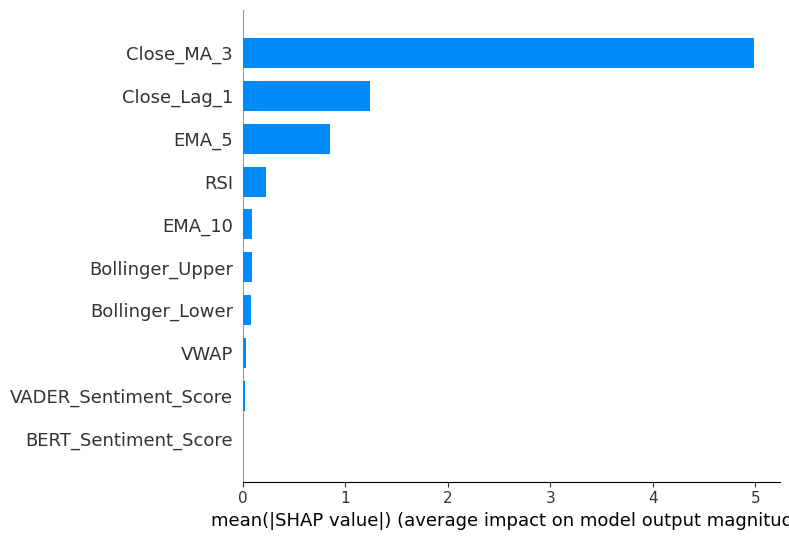

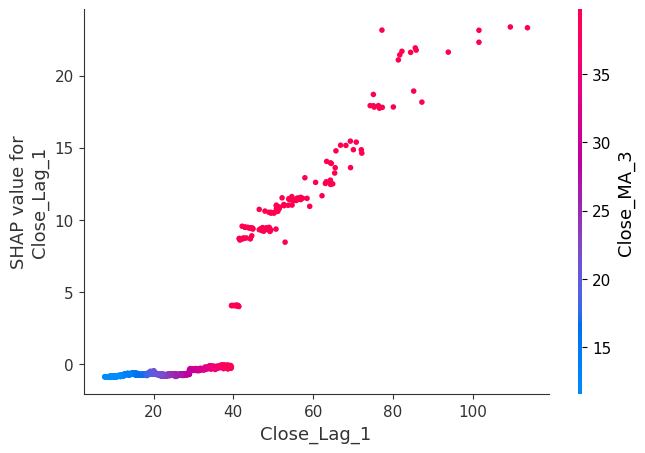

In [30]:
# Cross-Validation
cv_scores_lr = cross_val_score(lr_model, X, y, scoring='neg_mean_absolute_error', cv=5)
mean_cv_mae_lr = -cv_scores_lr.mean()

print(f"Cross-Validated MAE for Linear Regression: {mean_cv_mae_lr}")

# SHAP Analysis
import shap

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.dependence_plot("Close_Lag_1", shap_values, X_train)
